#**Deep Learning Homework 4: Recurrent Neural Networks & Transformer**

### MSc Computer Science, Data Science, Cybersecurity @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. We will use the IMDB dataset---it contains the text of some reviews and the sentiment given by their authors (either positive or negative). The input to the RNN is the sequence of words that compose a review, so the learning task consists in predicting the overall sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will solve the same classification problem with a Transformer, in order to have a closer look at its internal functioning.

**NOTE**: in order to run this notebook without problems, please connect to a *GPU runtime*. You can do so by clicking on the RAM / Disk icon in the upper right part of the notebook, then on *Change runtime tipe* at the bottom of the page, and then select the GPU hardware accelerator.  

##Exercise 4.1: Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [ ]:
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [ ]:
num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

Let's also get the word indexs (word to word-id)

In [ ]:
word_index = keras.datasets.imdb.get_word_index()

Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur. Notice that Keras does not use index 0, so we can shift the indices only by 3 positions.

In [ ]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [ ]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [ ]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [ ]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

### Model Definition
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer 

**[TO COMPLETE]** In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in `model.compile()` and motivate your choice.


Please, insert your answer in this text cell.

**Answer:** The problem is a binary classification problem with output 0 and 1, therefore it is adeguate to use a dense layer with a squishing function like the sigmoid whose range is \[0,1] and a binary crossentropy as the loss function. 

In [ ]:
model_simple = keras.models.Sequential()
model_simple.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_simple.add(keras.layers.SimpleRNN(32))
model_simple.add(keras.layers.Dense(1, activation = "sigmoid"))

model_simple.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [ ]:
model_simple.summary()

Model: "sequential_223"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_446 (Embedding)   (None, None, 10)          100000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1376      
                                                                 
 dense_892 (Dense)           (None, 1)                 33        
                                                                 
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


Now we have to train the model:

In [ ]:
start_simple_training = time.time()

history_simple = model_simple.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

end_simple_training = time.time()

print("Training time of SimpleRNN: {:.2f} seconds".format(end_simple_training - start_simple_training))

Epoch 1/10
196/196 [==============================] - 88s 444ms/step - loss: 0.6832 - accuracy: 0.5475 - val_loss: 0.6490 - val_accuracy: 0.6196
Epoch 2/10
196/196 [==============================] - 84s 430ms/step - loss: 0.5356 - accuracy: 0.7375 - val_loss: 0.4488 - val_accuracy: 0.8049
Epoch 3/10
196/196 [==============================] - 89s 454ms/step - loss: 0.3423 - accuracy: 0.8526 - val_loss: 0.4048 - val_accuracy: 0.8324
Epoch 4/10
196/196 [==============================] - 85s 431ms/step - loss: 0.2374 - accuracy: 0.9070 - val_loss: 0.5058 - val_accuracy: 0.7633
Epoch 5/10
196/196 [==============================] - 87s 442ms/step - loss: 0.1577 - accuracy: 0.9433 - val_loss: 0.4460 - val_accuracy: 0.8248
Epoch 6/10
196/196 [==============================] - 87s 444ms/step - loss: 0.0956 - accuracy: 0.9702 - val_loss: 0.4970 - val_accuracy: 0.8282
Epoch 7/10
196/196 [==============================] - 85s 433ms/step - loss: 0.0531 - accuracy: 0.9856 - val_loss: 0.5580 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['loss'], label='loss')
  plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
  plt.title('loss')
  plt.legend()

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['accuracy'], label='accuracy')
  plt.plot(history.epoch, history.history['val_accuracy'], label='val_accuracy')
  plt.title('accuracy')
  plt.legend()

391/391 - 14s - loss: 0.7031 - accuracy: 0.8208 - 14s/epoch - 35ms/step
accuracy: 82.08%


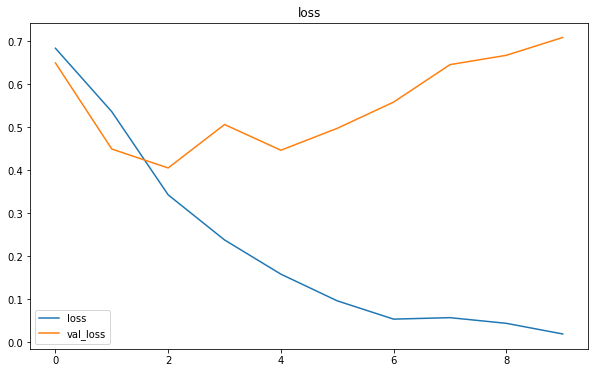

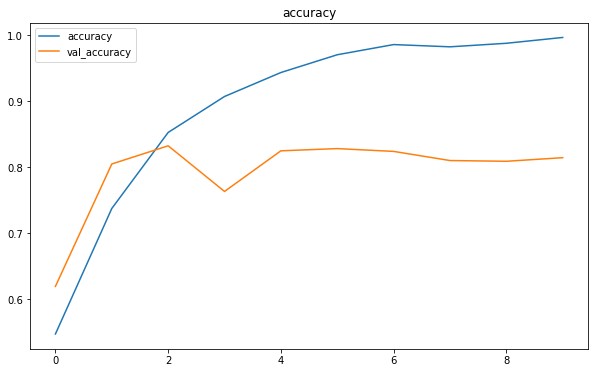

In [ ]:
plot_loss(history_simple)

plot_accuracy(history_simple)

scores_simple = model_simple.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_simple.metrics_names[1], scores_simple[1]*100))

## Exercise 4.2: LSTM and GRU
**[TO COMPLETE]**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

Model: "sequential_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_447 (Embedding)   (None, None, 10)          100000    
                                                                 
 lstm (LSTM)                 (None, 32)                5504      
                                                                 
 dense_893 (Dense)           (None, 1)                 33        
                                                                 
Total params: 105,537
Trainable params: 105,537
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 9s 24ms/step - loss: 0.5069 - accuracy: 0.7397 - val_loss: 0.3437 - val_accuracy: 0.8554
Epoch 2/10
196/196 [==============================] - 4s 22ms/step - loss: 0.3129 - accuracy: 0.8739 - val_loss: 0.3351 - val_accuracy: 0.8606
Epoch 3/10
196/196 [====

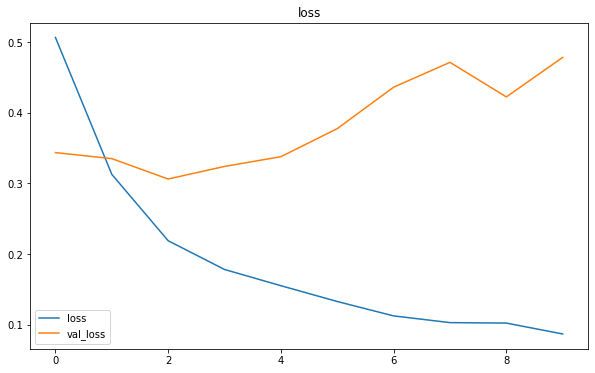

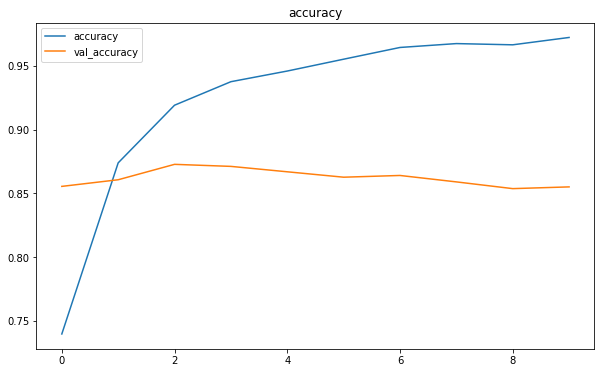

In [ ]:
# LSTM - complete with model definition, summary, fit and plots.
# LSTM with 32 units

model_lstm = keras.models.Sequential()
model_lstm.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_lstm.add(keras.layers.LSTM(32))
model_lstm.add(keras.layers.Dense(1, activation = "sigmoid"))

model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_lstm.summary()

start_lstm_training = time.time()
history_lstm = model_lstm.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))
end_lstm_training = time.time()

plot_loss(history_lstm)

plot_accuracy(history_lstm)

scores_lstm = model_lstm.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_lstm.metrics_names[1], scores_lstm[1]*100))
print("Training time of LSTM: {:.2f} seconds".format(end_lstm_training - start_lstm_training))

Model: "sequential_225"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_448 (Embedding)   (None, None, 10)          100000    
                                                                 
 gru (GRU)                   (None, 32)                4224      
                                                                 
 dense_894 (Dense)           (None, 1)                 33        
                                                                 
Total params: 104,257
Trainable params: 104,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 6s 23ms/step - loss: 0.5433 - accuracy: 0.7068 - val_loss: 0.3796 - val_accuracy: 0.8297
Epoch 2/10
196/196 [==============================] - 4s 21ms/step - loss: 0.2885 - accuracy: 0.8816 - val_loss: 0.3375 - val_accuracy: 0.8611
Epoch 3/10
196/196 [====

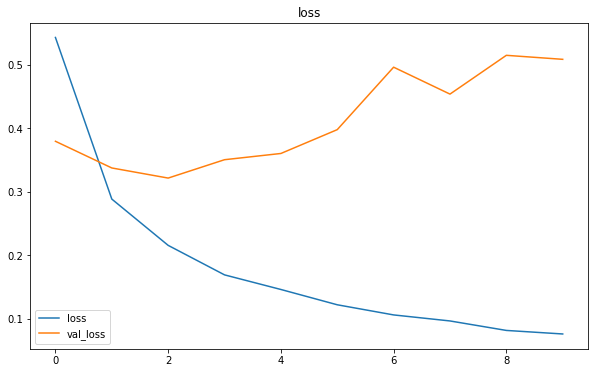

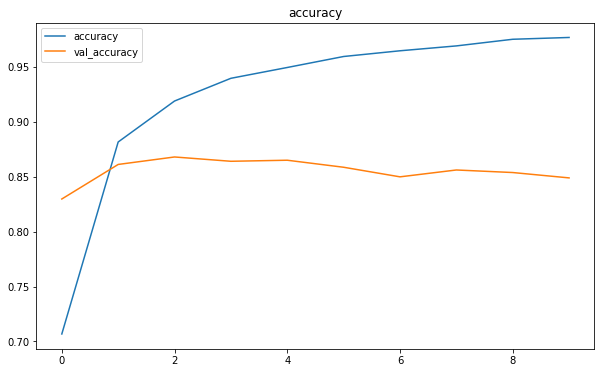

In [ ]:
# GRU - complete with model definition, summary, fit and plots.
# GRU with 32 nodes

model_gru = keras.models.Sequential()
model_gru.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_gru.add(keras.layers.GRU(32))
model_gru.add(keras.layers.Dense(1, activation = "sigmoid"))

model_gru.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_gru.summary()

start_gru_training = time.time()
history_gru = model_gru.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))
end_gru_training = time.time()

plot_loss(history_gru)

plot_accuracy(history_gru)

scores_gru = model_gru.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_gru.metrics_names[1], scores_gru[1]*100))
print("Training time of GRU: {:.2f} seconds".format(end_gru_training - start_gru_training))

**[TO COMPLETE]**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use?

**Insert cells (code and text) with results and discussion immediately after this cell** 



The simple RNN with SimpleRNN layer with 32 units has 1376 trainable paramenters in the SimpleRNN layer and 33 for the dense layer, while the LSTM and the GRU both with 32 units have respectively 5504 and 4224 trainable parameters in the recurrent layers and 33 for the dense layers each. 
- The number of parameters of the LSTM layer is 4 * ((size_of_input + 1) * size_of_output + size_of_output^2) = 4 * ((10+ 1) * 32+ 32^2) = 5504.
- The number of parameters of the GRU layer is 3 * ((size_of_output)^2 + size_of_input * size_of_output + 2 * size_of_output)= 3* (32^2 + 32  * 10 + 2 * 32) = 4224.

For the simple RNN we have 1376 + 33 = 1409 parameters, to match the number we need to reverse the formulas before (counting the dense layer too) and get the number of units for the LSTM and GRU layers. 

- For the LSTM 1376 + 33 = 4 * ((10+ 1) * n+ n^2) + (n + 1) gives n ≈ 14
- For th GRU 1376 + 33 = 3* (n^2 + n * 10 + 2 * n) + (n + 1) gives n ≈ 16

Now we explore both options.

Model: "sequential_226"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_449 (Embedding)   (None, None, 10)          100000    
                                                                 
 lstm_1 (LSTM)               (None, 14)                1400      
                                                                 
 dense_895 (Dense)           (None, 1)                 15        
                                                                 
Total params: 101,415
Trainable params: 101,415
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 6s 23ms/step - loss: 0.5850 - accuracy: 0.7056 - val_loss: 0.4145 - val_accuracy: 0.8199
Epoch 2/10
196/196 [==============================] - 4s 21ms/step - loss: 0.3381 - accuracy: 0.8637 - val_loss: 0.3342 - val_accuracy: 0.8654
Epoch 3/10
196/196 [====

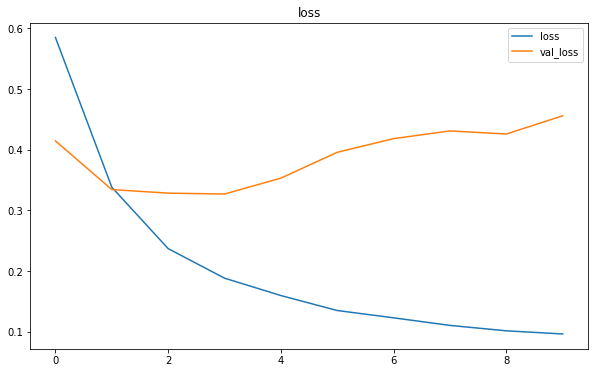

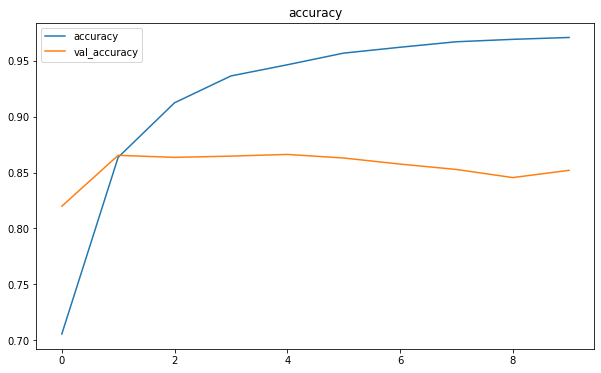

In [ ]:
# LSTM - complete with model definition, summary, fit and plots.
# LSTM with 14 units

model_lstm_cfr = keras.models.Sequential()
model_lstm_cfr.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_lstm_cfr.add(keras.layers.LSTM(14))
model_lstm_cfr.add(keras.layers.Dense(1, activation = "sigmoid"))

model_lstm_cfr.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_lstm_cfr.summary()

start_lstm_cfr_training = time.time()
history_lstm_cfr = model_lstm_cfr.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))
end_lstm_cfr_training = time.time()

plot_loss(history_lstm_cfr)

plot_accuracy(history_lstm_cfr)

scores_lstm_cfr = model_lstm_cfr.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_lstm_cfr.metrics_names[1], scores_lstm_cfr[1]*100))
print("Training time of LSTM with 14 units: {:.2f} seconds".format(end_lstm_cfr_training - start_lstm_cfr_training))

Model: "sequential_227"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_450 (Embedding)   (None, None, 10)          100000    
                                                                 
 gru_1 (GRU)                 (None, 16)                1344      
                                                                 
 dense_896 (Dense)           (None, 1)                 17        
                                                                 
Total params: 101,361
Trainable params: 101,361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 6s 23ms/step - loss: 0.5642 - accuracy: 0.6831 - val_loss: 0.3835 - val_accuracy: 0.8345
Epoch 2/10
196/196 [==============================] - 4s 21ms/step - loss: 0.2920 - accuracy: 0.8838 - val_loss: 0.3316 - val_accuracy: 0.8605
Epoch 3/10
196/196 [====

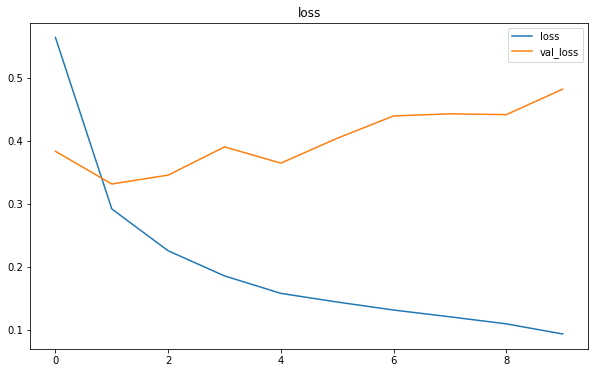

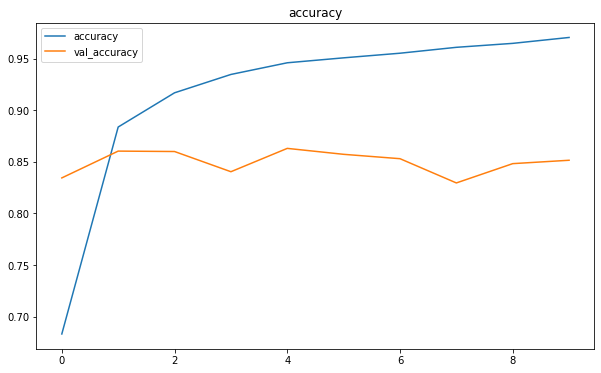

In [ ]:
# GRU - complete with model definition, summary, fit and plots.
# GRU with 16 units

model_gru_cfr = keras.models.Sequential()
model_gru_cfr.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_gru_cfr.add(keras.layers.GRU(16))
model_gru_cfr.add(keras.layers.Dense(1, activation = "sigmoid"))

model_gru_cfr.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_gru_cfr.summary()

start_gru_cfr_training = time.time()
history_gru_cfr = model_gru_cfr.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))
end_gru_cfr_training = time.time()

plot_loss(history_gru_cfr)

plot_accuracy(history_gru_cfr)

scores_gru_cfr = model_gru_cfr.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_gru_cfr.metrics_names[1], scores_gru_cfr[1]*100))
print("Training time of GRU with 16 units: {:.2f} seconds".format(end_gru_cfr_training - start_gru_cfr_training))

First we check that we have roughtly the same amout of parameters:
- Simple RNN: 101,409 
- LTSM: 101,415
- GRU: 101,361

They are circa the same. 
Now We can discuss the time taken and accuracies: 

- SIMPLE - 923s - train_acc: 0.9978 - val_acc: 0.8048 - test_acc: 0.8093 

- LTSM - 56s - train_acc: 0.9694 - val_acc: 0.8539 - test_acc: 0.8611

- GRU - 83s - train_acc: 0.9777 - val_acc: 0.8514 - test_acc: 0.8566

We can see that LTSM and GRU outperforms the simple RNN both in time and in accuracies but there is a clear problem of overfitting in all three of the models since the training accuracy is way greater than the validation accuracy. 

### Bidirectional LSTM
In conclusion, let's also have a look at the performances of a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [ ]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

start_bidirectional_training = time.time()
history_bidirectional = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))
end_bidirectional_training = time.time()

print("Training time of Bidirectional: {:.2f} seconds".format(end_gru_training - start_gru_training))

Model: "sequential_228"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_451 (Embedding)   (None, None, 10)          100000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               11008     
 l)                                                              
                                                                 
 dense_897 (Dense)           (None, 1)                 65        
                                                                 
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 11s 42ms/step - loss: 0.5511 - accuracy: 0.7144 - val_loss: 0.3658 - val_accuracy: 0.8466
Epoch 2/5
196/196 [==============================] - 7s 38ms/step - loss: 0.2907 - accuracy: 0.8864 -

391/391 - 5s - loss: 0.3191 - accuracy: 0.8770 - 5s/epoch - 13ms/step
accuracy: 87.70%


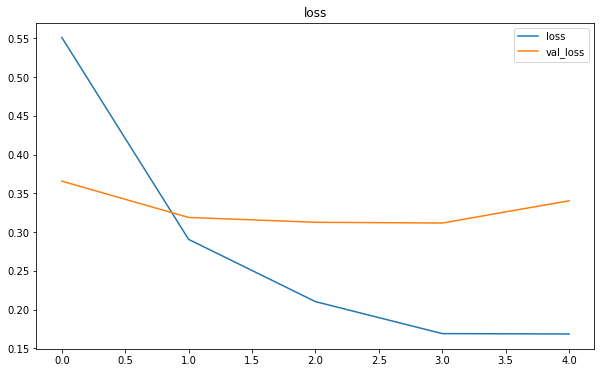

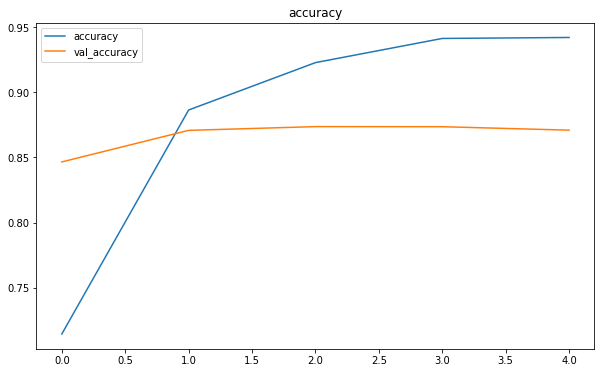

In [ ]:
plot_loss(history_bidirectional)

plot_accuracy(history_bidirectional)

scores_bidirectional = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores_bidirectional[1]*100))

## Exercise 4.3: Transformer

Let's now use a [Transformer](https://arxiv.org/abs/1706.03762) to perform the same task considered in the previous exercise. To define the Transformer we will define a class that inherits from [tensorflow.keras.layers.Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer). This class represents a layer, that is a callable object that takes as input one or more tensors and that outputs one or more tensors. It involves computation, defined in the `call()` method, and a state (weight variables), both defined in the constructor. In the following cell, we will override these two methods in order to define the TransformerLayer. 

The structure of the transformer is defined as follows:
*   A multi-head attention layer, defined using the [tensorflow.keras.layers.MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)
*   Dropout operation (*dropout_att*)
*   Layer Normalization (*layernorm_att*)
*   A feedforward Neural Network, defenid by using keras.Sequential, and Dense layer
*   Dropout operation (*dropout_fnn*)
*   Layer Normalization (*layernorm_fnn*) that has in input the summation of the attention layer output and the feedforward NN output



In [ ]:
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_att = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm_fnn = layers.LayerNormalization(epsilon=1e-6)
        self.dropout_att = layers.Dropout(rate)
        self.dropout_fnn = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout_att(attn_output, training=training)
        out1 = self.layernorm_att(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout_fnn(ffn_output, training=training)
        return self.layernorm_fnn(out1 + ffn_output)

Due to memory constraints of Transformers the maxlen is reduced to 200.

In [ ]:
maxlen = 200
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

To manage the sequential structure of the input, we need to create an embedding of the word + a positional embedding. To perform this operation, similarly to what we did for defining the Transformer layer, we define a new class that inherits from *layer.Layers*. In the unbatched (i.e. single-input) version, this class has in input the index of a word and computes 2 embeddings: the embedding of the word, and the positional embedding. Finally, the method returns the summation of these two embeddings.

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Now we can define the Transformer model. The model is defined as follows:

*   the Input layer
*   the TokenAndPositionEmbedding layer
*   the Transformer layer
*   2 Dense layers, the second one is the output layer.


**[TO COMPLETE]** Experiment with the `embed_dim, num_heads, ff_dim` and discuss the influence of these parameters in the obtained results, considering the accuracy of the output at the time required to perform the training phase. Report the discussion in the cell at the end of the notebook.

In [ ]:
embed_dim = 10  # Embedding size for each token
num_heads = 10  # Number of attention heads
ff_dim = 10  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, num_words, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train_trim, y_train, batch_size=128, epochs=5, validation_data=(X_valid_trim, y_valid)
)

Epoch 1/5
196/196 [==============================] - 9s 40ms/step - loss: 0.4938 - accuracy: 0.7510 - val_loss: 0.3366 - val_accuracy: 0.8528
Epoch 2/5
196/196 [==============================] - 8s 38ms/step - loss: 0.2536 - accuracy: 0.9023 - val_loss: 0.3125 - val_accuracy: 0.8685
Epoch 3/5
196/196 [==============================] - 8s 38ms/step - loss: 0.1955 - accuracy: 0.9278 - val_loss: 0.3365 - val_accuracy: 0.8655
Epoch 4/5
196/196 [==============================] - 8s 38ms/step - loss: 0.1574 - accuracy: 0.9462 - val_loss: 0.3882 - val_accuracy: 0.8621
Epoch 5/5
196/196 [==============================] - 8s 39ms/step - loss: 0.1334 - accuracy: 0.9563 - val_loss: 0.4147 - val_accuracy: 0.8558


In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['loss'], label='loss')
  plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
  plt.title('loss')
  plt.legend()

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['accuracy'], label='accuracy')
  plt.plot(history.epoch, history.history['val_accuracy'], label='val_accuracy')
  plt.title('accuracy')
  plt.legend()

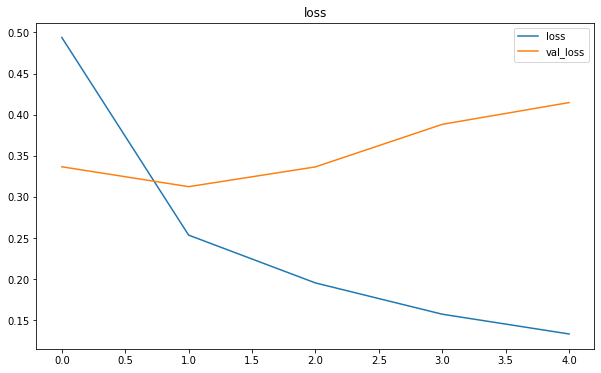

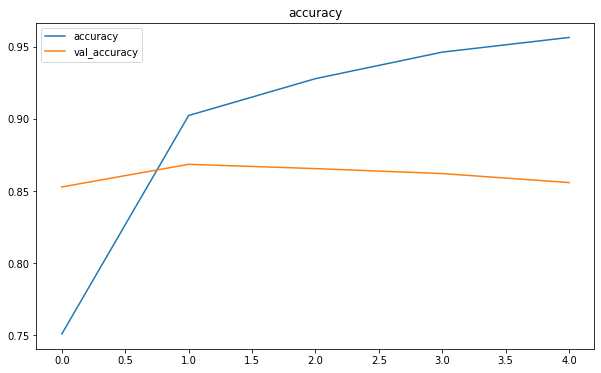

In [ ]:
plot_loss(history)

plot_accuracy(history)

### GridSearch

In [ ]:
#embed_dim = 10  # Embedding size for each token
#num_heads = 10  # Number of attention heads
#ff_dim = 10  # Hidden layer size in feed forward network inside transformer

def gridsearch_function(embed_dim = 10, num_heads = 10, ff_dim = 10):
  inputs = layers.Input(shape=(maxlen,))
  embedding_layer = TokenAndPositionEmbedding(maxlen, num_words, embed_dim)
  x = embedding_layer(inputs)
  transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
  x = transformer_block(x)
  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(20, activation="relu")(x)
  x = layers.Dropout(0.1)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
  history = model.fit(
      X_train_trim, y_train, batch_size=128, epochs=5, validation_data=(X_valid_trim, y_valid), verbose = 0
      )
  scores = model.evaluate(X_valid_trim, y_valid, verbose=0)
  return scores[1]

#### First grid search

In [ ]:
embed_dim_list = [5,10,20]
num_heads_list = [5,10,20]
ff_dim_list = [5,10,20]

result_dict = dict()
best_valid_acc = 0
best_hyperparameters = None

for embed_dim in embed_dim_list: 
  for num_heads in num_heads_list:
    for ff_dim in ff_dim_list: 
      
      start = time.time()
      t = (embed_dim,num_heads,ff_dim)
      result = gridsearch_function(embed_dim = embed_dim , num_heads = num_heads, ff_dim = ff_dim)
      result_dict[t] = result

      if result > best_valid_acc: 
        best_valid_acc = result
        best_hyperparameters = t
        print("Best hyperparameters adjusted!")

      end = time.time()
      duration = end - start
      print("This iteration was with hyperparameters {}, lasted {:.2f} and had a validation accuracy of {:.5f}".format(t,duration,result))

Best hyperparameters adjusted!
This iteration was with hyperparameters (5, 5, 5), lasted 23.06 and had a validation accuracy of 0.84592
Best hyperparameters adjusted!
This iteration was with hyperparameters (5, 5, 10), lasted 23.07 and had a validation accuracy of 0.86072
This iteration was with hyperparameters (5, 5, 20), lasted 23.50 and had a validation accuracy of 0.86048
This iteration was with hyperparameters (5, 10, 5), lasted 37.25 and had a validation accuracy of 0.85976
This iteration was with hyperparameters (5, 10, 10), lasted 37.96 and had a validation accuracy of 0.85032
Best hyperparameters adjusted!
This iteration was with hyperparameters (5, 10, 20), lasted 37.58 and had a validation accuracy of 0.86296
This iteration was with hyperparameters (5, 20, 5), lasted 66.49 and had a validation accuracy of 0.85472
This iteration was with hyperparameters (5, 20, 10), lasted 67.19 and had a validation accuracy of 0.85608
This iteration was with hyperparameters (5, 20, 20), last

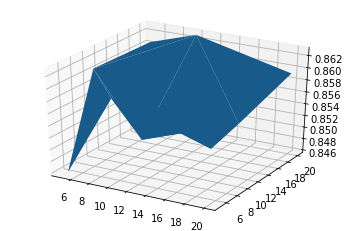

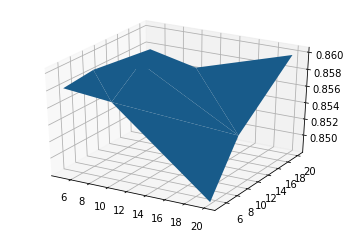

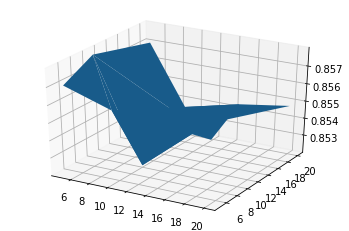

In [ ]:
for something in [5,10,20]:
  #modify the dictionary: i want to plot only (something , * , *)
  mod_dic = dict()
  for tupl in [(a,b,c) for a in [5,10,20] for b in [5,10,20] for c in [5,10,20]]:
    if tupl[0] == something:
      mod_dic[(tupl[1],tupl[2])] = result_dict[tupl]
  
  c = list(mod_dic.values())

  # we have to unpack the dictionary values into two variables, b and c 
  a,b = zip(*mod_dic.keys())

  # Now plotting 
  fig = plt.figure()
  pr = fig.gca(projection='3d')
  pr.plot_trisurf(a, b, c)

#### Second grid search

In [ ]:
embed_dim_list = [3,5,8]
num_heads_list = [3,5,8]
ff_dim_list = [3,5,8]

result_dict = dict()
best_valid_acc = 0
best_hyperparameters = None

for embed_dim in embed_dim_list: 
  for num_heads in num_heads_list:
    for ff_dim in ff_dim_list: 
      
      start = time.time()
      t = (embed_dim,num_heads,ff_dim)
      result = gridsearch_function(embed_dim = embed_dim , num_heads = num_heads, ff_dim = ff_dim)
      result_dict[t] = result

      if result > best_valid_acc: 
        best_valid_acc = result
        best_hyperparameters = t
        print("Best hyperparameters adjusted!")

      end = time.time()
      duration = end - start
      print("This iteration was with hyperparameters {}, lasted {:.2f} and had a validation accuracy of {:.5f}".format(t,duration,result))

Best hyperparameters adjusted!
This iteration was with hyperparameters (3, 3, 3), lasted 17.25 and had a validation accuracy of 0.82048
Best hyperparameters adjusted!
This iteration was with hyperparameters (3, 3, 5), lasted 17.82 and had a validation accuracy of 0.85072
Best hyperparameters adjusted!
This iteration was with hyperparameters (3, 3, 8), lasted 17.22 and had a validation accuracy of 0.85208
This iteration was with hyperparameters (3, 5, 3), lasted 22.58 and had a validation accuracy of 0.84504
This iteration was with hyperparameters (3, 5, 5), lasted 24.33 and had a validation accuracy of 0.83544
This iteration was with hyperparameters (3, 5, 8), lasted 22.73 and had a validation accuracy of 0.85152
Best hyperparameters adjusted!
This iteration was with hyperparameters (3, 8, 3), lasted 30.50 and had a validation accuracy of 0.86480
This iteration was with hyperparameters (3, 8, 5), lasted 30.44 and had a validation accuracy of 0.85616
This iteration was with hyperparamet

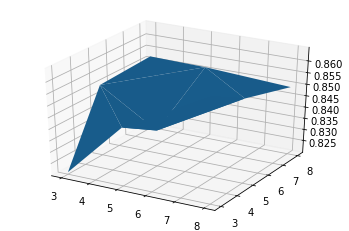

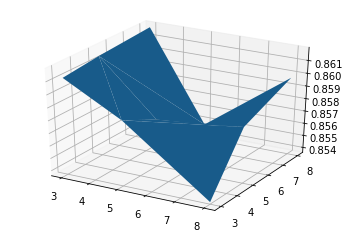

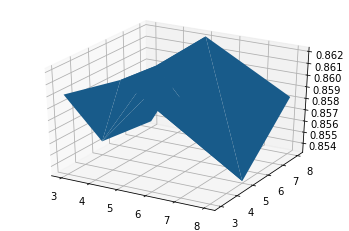

In [ ]:
for something in [3,5,8]:
  #modify the dictionary: i want to plot only (something , * , *)
  mod_dic = dict()
  for tupl in [(a,b,c) for a in [3,5,8] for b in [3,5,8] for c in [3,5,8]]:
    if tupl[0] == something:
      mod_dic[(tupl[1],tupl[2])] = result_dict[tupl]
  
  c = list(mod_dic.values())

  # we have to unpack the dictionary values into two variables, b and c 
  a,b = zip(*mod_dic.keys())

  # Now plotting 
  fig = plt.figure()
  pr = fig.gca(projection='3d')
  pr.plot_trisurf(a, b, c)

#### Third grid search

In [ ]:
embed_dim_list = [1,2,3,4,5]
num_heads_list = [1,2,3,4,5]
ff_dim_list = [1,2,3,4,5]

result_dict = dict()
best_valid_acc = 0
best_hyperparameters = None

for embed_dim in embed_dim_list: 
  for num_heads in num_heads_list:
    for ff_dim in ff_dim_list: 
      
      start = time.time()
      t = (embed_dim,num_heads,ff_dim)
      result = gridsearch_function(embed_dim = embed_dim , num_heads = num_heads, ff_dim = ff_dim)
      result_dict[t] = result

      if result > best_valid_acc: 
        best_valid_acc = result
        best_hyperparameters = t
        print("Best hyperparameters adjusted!")

      end = time.time()
      duration = end - start
      print("This iteration was with hyperparameters {}, lasted {:.2f} and had a validation accuracy of {:.5f}".format(t,duration,result))

Best hyperparameters adjusted!
This iteration was with hyperparameters (1, 1, 1), lasted 11.75 and had a validation accuracy of 0.49472
Best hyperparameters adjusted!
This iteration was with hyperparameters (1, 1, 2), lasted 12.84 and had a validation accuracy of 0.50528
This iteration was with hyperparameters (1, 1, 3), lasted 16.15 and had a validation accuracy of 0.50528
This iteration was with hyperparameters (1, 1, 4), lasted 12.68 and had a validation accuracy of 0.50528
This iteration was with hyperparameters (1, 1, 5), lasted 14.09 and had a validation accuracy of 0.49472
This iteration was with hyperparameters (1, 2, 1), lasted 17.81 and had a validation accuracy of 0.49472
This iteration was with hyperparameters (1, 2, 2), lasted 15.00 and had a validation accuracy of 0.50528
This iteration was with hyperparameters (1, 2, 3), lasted 14.07 and had a validation accuracy of 0.50528
This iteration was with hyperparameters (1, 2, 4), lasted 23.19 and had a validation accuracy of 0

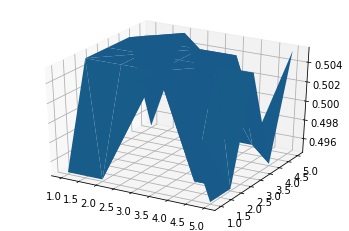

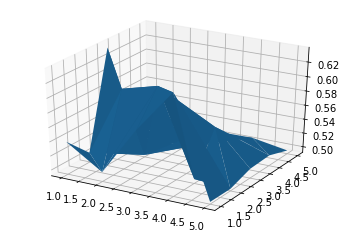

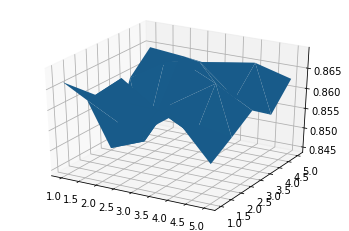

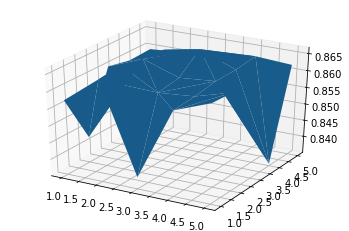

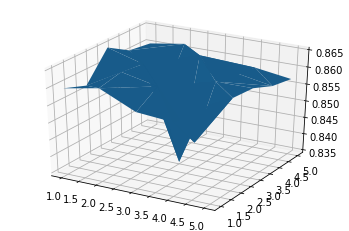

In [ ]:
for something in [1,2,3,4,5]:
  #modify the dictionary: i want to plot only (something , * , *)
  mod_dic = dict()
  for tupl in [(a,b,c) for a in [1,2,3,4,5] for b in [1,2,3,4,5] for c in [1,2,3,4,5]]:
    if tupl[0] == something:
      mod_dic[(tupl[1],tupl[2])] = result_dict[tupl]
  
  c = list(mod_dic.values())

  # we have to unpack the dictionary values into two variables, b and c 
  a,b = zip(*mod_dic.keys())

  # Now plotting 
  fig = plt.figure()
  pr = fig.gca(projection='3d')
  pr.plot_trisurf(a, b, c)

### Final model

Epoch 1/3
196/196 [==============================] - 5s 18ms/step - loss: 0.6272 - accuracy: 0.6489 - val_loss: 0.4051 - val_accuracy: 0.8340
Epoch 2/3
196/196 [==============================] - 3s 16ms/step - loss: 0.3139 - accuracy: 0.8746 - val_loss: 0.3004 - val_accuracy: 0.8728
Epoch 3/3
196/196 [==============================] - 3s 16ms/step - loss: 0.2301 - accuracy: 0.9134 - val_loss: 0.3107 - val_accuracy: 0.8722
391/391 - 1s - loss: 0.2991 - accuracy: 0.8767 - 1s/epoch - 3ms/step


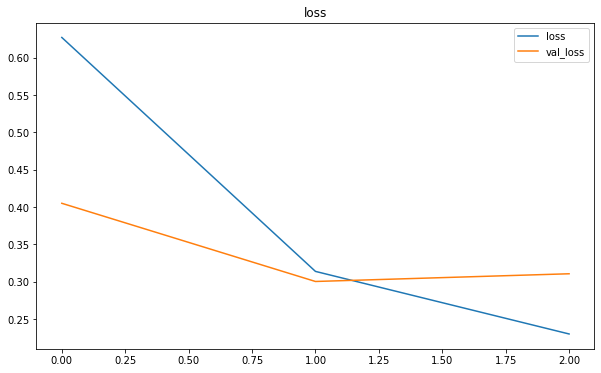

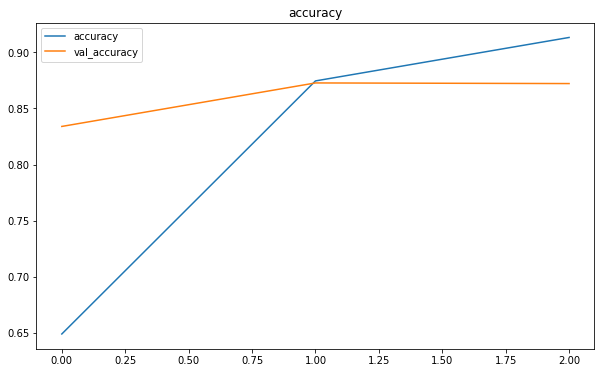

In [ ]:
embed_dim = 3 # Embedding size for each token
num_heads = 3  # Number of attention heads
ff_dim = 3  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, num_words, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train_trim, y_train, batch_size=128, epochs=3, validation_data=(X_valid_trim, y_valid)
)

plot_loss(history)
plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)

### Comments

We can see that if embed_dim or num_heads increase then the running time increases, while if ff_dim increases the running time remeans stable. From the first grid search we could see that it was not necessary to use big numbers so I decided to use smaller hyperparameters performing a second grid search and I achived the same accuracy (even slighlty better). I decided to reduce even more the size of the hyperparameters and perform a third grid search trying to improve even more the result and it happended: the best accuracy at the end was found in the third grid search with the choice of embed_dim = 3, num_heads = 3 and ff_dim = 3 the validation accuracy was 86.952%.. The model is quite fast too since the training with the chosen hyperparameters takes only a few seconds per epochs (actually all the searches on the grid searches were made on 5 epochs). At last I trained the model with embed_dim = num_heads = ff_dim = 3 and i saw that with 3 epoch the accuracy on the validation set was maximized so i decided to use 3 epochs and with those choices the accuracy on the validation set was 87.22% and on the test set was 87.67%.